# Customer Churn Analysis and Prediction - Data Mining 2 Project
Josh King

## Table of Contents

* [Setup and Cleaning](#Setup-and-Cleaning)
 * [Notebook and Dataframe Setup](#Notebook-and-Dataframe-Setup)
 * [Initial Inspection](#Initial-Inspection)
 * [Qualitative Variable Cleaning](#Qualitative-Variable-Cleaning)
 * [Quantitative Variable Cleaning](#Quantitative-Variable-Cleaning)
 * [Overall Cleaning Check](#Overall-Cleaning-Check)
* [Univariate Exploration](#Univariate-Exploration)
* [Bivariate Exploration](#Bivariate-Exploration)
 * [Quantitative Correlation Analysis](#Quantitative-Correlation-Analysis)
 * [Quantitative Variables Against Response](#Quantitative-Variables-Against-Response)
 * [Qualitative Correlation and Response Analysis](#Qualitative-Correlation-and-Response-Analysis)
 * [Conclusions From Bivariate Analysis](#Conclusions-From-Bivariate-Analysis)
* [Data Preparation for Predictive Methods](#Data-Preparation-for-Predictive-Methods)
 * [Cleaned Dataset](#Cleaned-Dataset)
 * [Dimension Reduction Exploration](#Dimension-Reduction-Exploration)
 * [Train/Validate/Test Set Preparations](#Train/Validate/Test-Set-Preparations)
* [Predictive Evaluation](#Predictive-Evaluation)
 * [Logistic Regression](#Logistic-Regression)
 * [Random Forest](#Random-Forest)
 * [Comparison of Models](#Comparison-of-Models)
 * [Final Model Evaluation](#Final-Model-Evaluation)

## Setup and Cleaning

### Notebook and Dataframe Setup

In [1]:
# Import the primary libraries used for general data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Use Seaborn's set function to change the data visualization style preferences
sb.set()

# Import various tools used for data preparation and model building
import prince # for FMDA
from scipy.stats import mannwhitneyu, chi2_contingency # for statistical tests
from sklearn.preprocessing import StandardScaler # for standardizing data
from sklearn.model_selection import train_test_split, ParameterGrid # tools used in model building
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix # for evaluating models
from sklearn.ensemble import RandomForestClassifier # for model building
from statsmodels.formula.api import logit # for model building

In [2]:
# Import our csv file and check the top few lines
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

### Initial Inspection

First we print a general description of the dataset to look for any obvious abnormalities.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

From the readout above and the print of the dataframe's head, we can make a few claims:
* There are a considerable number of variables (21)
* No variable has obviously missing values (though we should scrutinize further given the high number of qualitative variables here)
* The `TotalCharges` variable appears to be of the wrong type.
* `SeniorCitizen` is encoding as a boolean which is inconsistent with the other qualitative encodings.
* Column titles are inconsistently capitalized.

Before we address these concerns, let's divy up the columns into some helpful variables given their number. We know from the assignment that the target variable will be `Churn`.

Let's also copy our dataframe to a clean version `dfc` to work on.

In [4]:
# Setting up a cleaned dataframe to work on
dfc = df.copy()

# Renaming the columns with consistent case
dfc.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure':'Tenure'}, inplace=True)

# Setting up some help variables for the columns
cols = list(dfc)
qualcols = list(set(cols) - {'CustomerID', 'MonthlyCharges', 'TotalCharges', 'Tenure'})
quantcols = ['MonthlyCharges', 'TotalCharges', 'Tenure']

# The datasets total features are everything except the target and ID column
features = cols
features.remove('CustomerID')
features.remove('Churn')

### Qualitative Variable Cleaning

From looking at the dataframe's head, each categorical variable seems likely to have only a small number of level - enough to inspect manually for duplicates, blanks, or aberrant values. Let's loop through each to get a print of the levels.

In [5]:
# Print each qualitative variable name and its levels
for column in qualcols:
    print(column)
    print(dfc[column].unique())

StreamingTV
['No' 'Yes' 'No internet service']
Gender
['Female' 'Male']
OnlineSecurity
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
InternetService
['DSL' 'Fiber optic' 'No']
Contract
['Month-to-month' 'One year' 'Two year']
StreamingMovies
['No' 'Yes' 'No internet service']
PhoneService
['No' 'Yes']
Partner
['Yes' 'No']
Churn
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
PaperlessBilling
['Yes' 'No']
Dependents
['No' 'Yes']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
SeniorCitizen
[0 1]
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']


The above looks surprisingly clean, though we can see how `SeniorCitizen` is encoded differently. Let's also encode that as "Yes"/"No" to be consistent with the other qualitative variables.

In [6]:
# Do the replacement
dfc.SeniorCitizen.replace({0:'No', 1:'Yes'}, inplace=True)
# Check the results
dfc.SeniorCitizen.unique()

array(['No', 'Yes'], dtype=object)

Finally let's check for duplicates within our id column.

In [7]:
dfc.duplicated(subset='CustomerID').sum()

0

No duplicates found. So no cleaning needed on the qualitative variables yet.

### Quantitative Variable Cleaning

First let's change our `TotalCharges` variable to numeric.

In [8]:
# Make the change and coerce erorrs in NaN values
dfc['TotalCharges'] = pd.to_numeric(dfc.TotalCharges, errors='coerce')

# And print how many were turned NaN
dfc.TotalCharges.isna().sum()

11

As there are only 11 missing values from this dataset of over seven thousand, it is reasonable to drop these to maintain a consistent analysis.

In [9]:
dfc.dropna(inplace=True)

Next let's take a broad look at our quantitative variables to see if anything obvious sticks out.

In [10]:
dfc.describe()

Tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

Nothing is obviously wrong when reviewing the general distributions and min/max of the variables above. There does not appear to be any further obvious cleaning needed.

### Overall Cleaning Check

Let's do one last check of the general dataframe info to make sure everything is as expected.

In [11]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
CustomerID          7032 non-null object
Gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
Tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(1), o

Everything looks good in the above. There are no apparent missing cells and all data types are as expected. Any further cleaning would require deeper dives into the variables individually, but as is we can reasonably begin looking at variable distributions.

## Univariate Exploration
For this section we'll look at each variable individually. While this might not be necessary (we might, for instance, start with a correlation analysis to see which variables were relevant), the project prompt requested prints for each variable.

First let's look at the distribution of our **target variable** `Churn`.

In [12]:
# Relative frequency of those who do churn 
churn_freq = (dfc['Churn'] == 'Yes').sum() / len(dfc)

# Printing both values
print(churn_freq, (1 - churn_freq))

0.26578498293515357 0.7342150170648465


Given the frequency of churn is above 25% here, we could reasonably use the dataset directly without oversampling the event variable.

Now let's do a histogram for each of our **quantitative variables**.

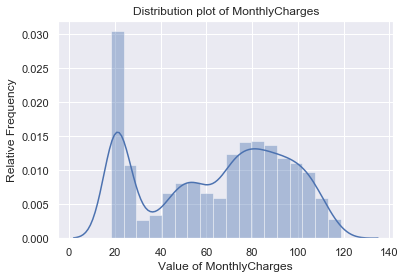

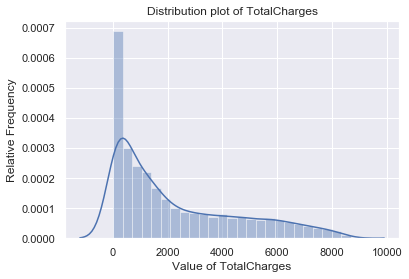

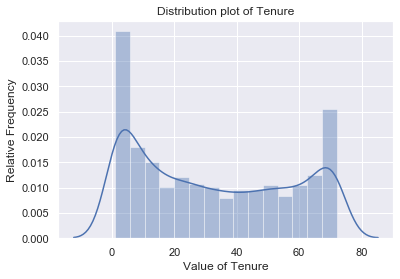

In [13]:
# Histogram for each quantitative variable
for var in quantcols:
    sb.distplot(dfc[var])
    plt.title("Distribution plot of {}".format(var))
    plt.ylabel("Relative Frequency")
    plt.xlabel("Value of {}".format(var))
    plt.show()

We can also do a quick outlier check using the interquartile range method:

In [14]:
# Print the number of outliers for each quantitative variable
for var in quantcols:
    lq = dfc[var].quantile(0.25)
    uq = dfc[var].quantile(0.75)
    outlier_iqr = 1.5 * (uq - lq)
    num_outliers = (dfc[var] >= (uq + outlier_iqr)).sum() + (dfc[var] <= (lq - outlier_iqr)).sum()
    print("{} number of outliers:  {}".format(var, num_outliers))

MonthlyCharges number of outliers:  0
TotalCharges number of outliers:  0
Tenure number of outliers:  0


From the above prints we may make a few claims:
* `Tenure` is considerably bi-modal with peaks near ~5 and ~70.
* `MonthlyCharges` has no obvious distribution.
* `TotalCharges` is considerably right-skewed.
* There are no obvious outliers within any distrubtion.

Given the above notes, we might consider transformations of the variables, especially `TotalCharges`, in future analysis. We might also consider the obvious non-normal distributions when performing any statistical tests.

Now let's look at the distributions of our **qualitative variables**.

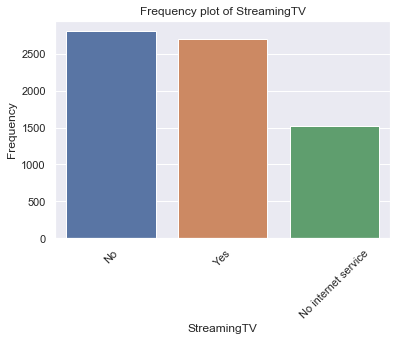

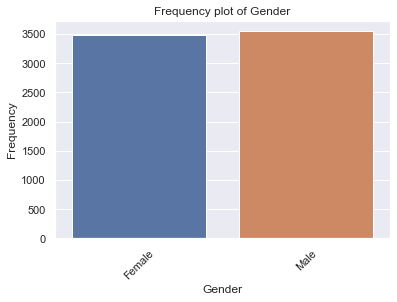

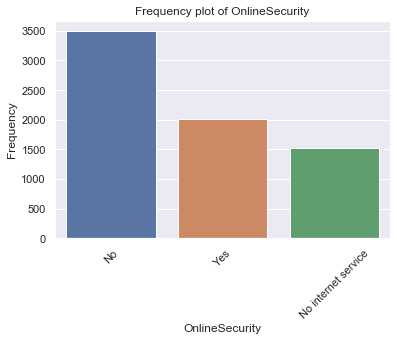

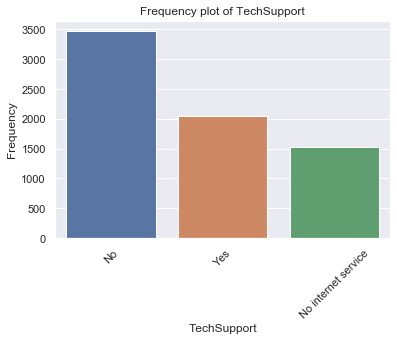

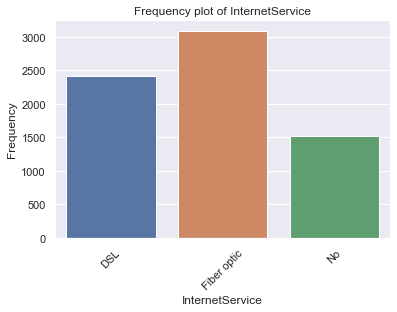

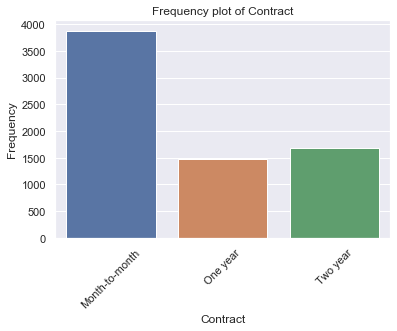

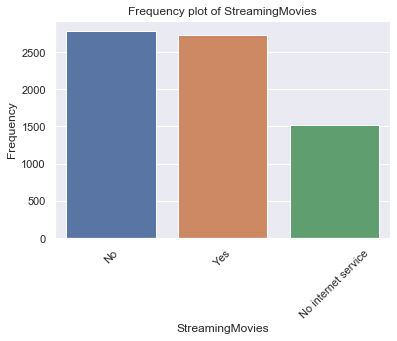

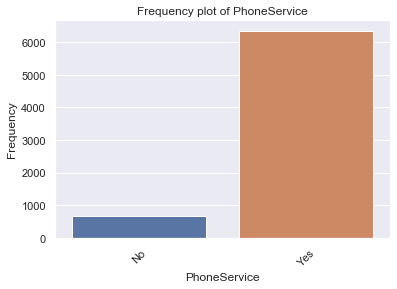

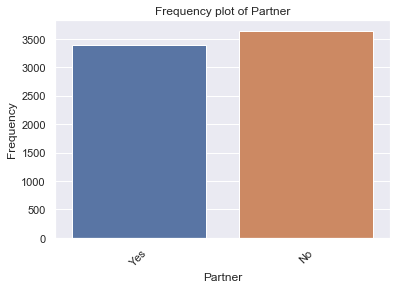

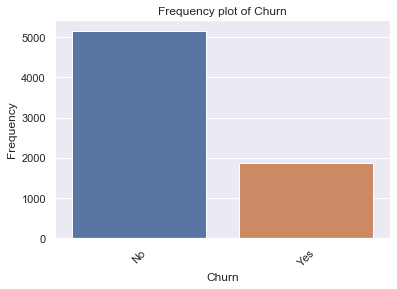

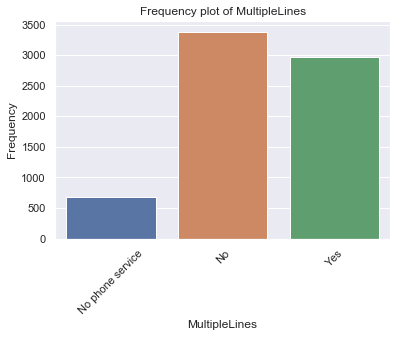

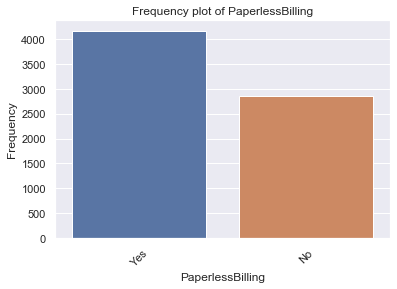

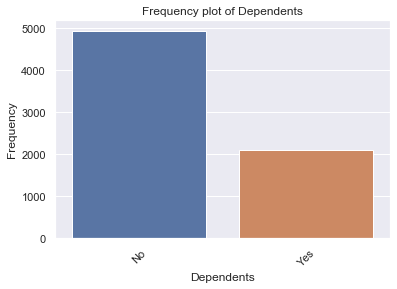

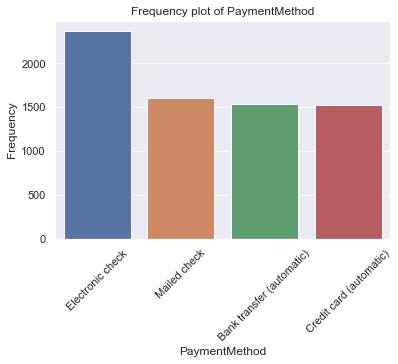

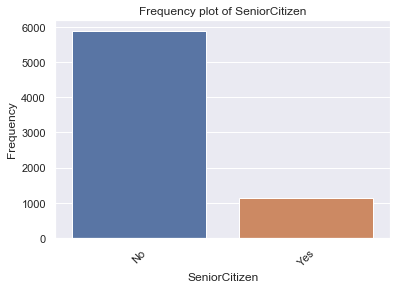

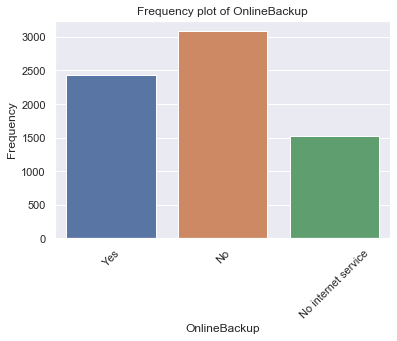

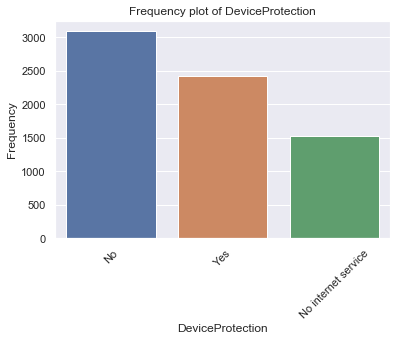

In [15]:
# Countplot for each qualitative variable
for var in qualcols:
    sb.countplot(dfc[var])
    plt.title("Frequency plot of {}".format(var))
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

In reviewing the above, while some levels differ greatly, no variable has a distribution so extreme as to take further action. `SeniorCitizen`, `MultipleLines`, and `PhoneService` have the most extreme observations, but none of these have levels substatianlly less than 1/6 of the highest frequency level. No major adaptations of our analysis stand out at this level of exploration.

## Bivariate Exploration

### Quantitative Correlation Analysis

First let's compare our quantitative variables against themselves to check for any correlations. Two easy ways to do these are through a pairplot and print of correlation ceofficients.

First let's review the pairplot.

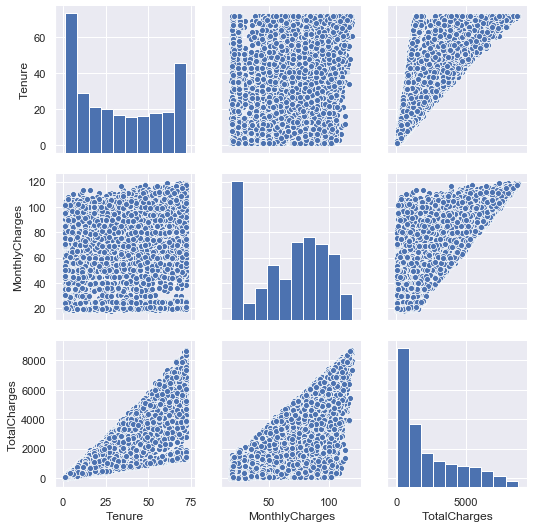

In [16]:
# Pairplot of quantitative variables
sb.pairplot(dfc)
plt.show()

We'll reserve describing the plot above until we've also looked at the correlation coefficients. Here we can get the Pearson correlation coefficients from the below code.

In [17]:
# Pearson correlation coefficients for quantitative variables
dfc.corr()

Tenure  MonthlyCharges  TotalCharges
Tenure          1.000000        0.246862      0.825880
MonthlyCharges  0.246862        1.000000      0.651065
TotalCharges    0.825880        0.651065      1.000000

In reviewing the above two outputs, we can make the following claims:
* `Tenure` and `MonthlyCharges` do not appear particularly correlated
* `Tenture` and `TotalCharges` are strongly, positively correlated with increasing variance at higher values. Interestingly the increase variance only exists in one direction (towards smaller total charges). For every value of tenure, there is a cap on how high the total charges can be.
* `TotalCharges` and `MonthlyCharges` show moderate positive correlation with a similar behavior to that of the relationship between `Tenure` and `TotalCharges`.

We might reasonably expect that the "cutoff" line seen in the correlated variables along with the increasing variance is due to some other confounding variable. Due to the fairly high `Tenure` and `TotalCharges` correlation, we might run into issues with collinearity in a regression model. Noting the above, this gives us cause to consider dropping one of the variables, or to use a different model type (either machine learning or some sort of factor/component analysis).

### Quantitative Variables Against Response

Now let's look how our quantitative variables look when measuring against our response variable `Churn`. We can use box plots to compare each distribution.

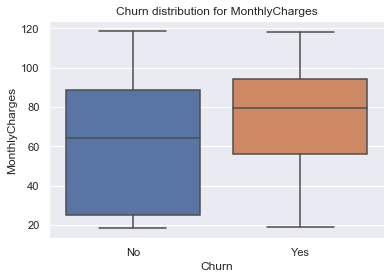

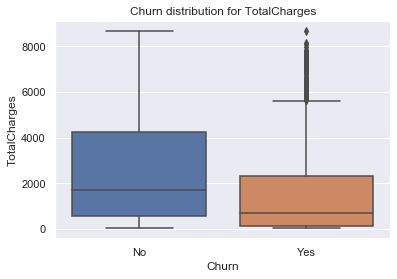

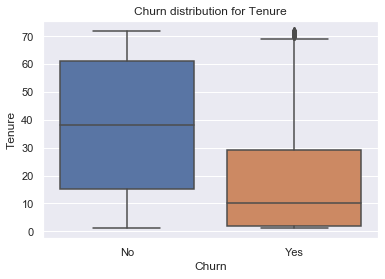

In [18]:
# Box plots of each quantitative variables against response
for var in quantcols:
    sb.boxplot(x='Churn', y=var, data=dfc)
    plt.title("Churn distribution for {}".format(var))
    plt.show()

In reviewing the above, we might notice:
* In general `Churn` = Yes is (compared to No) associated with:
 * Lower `Tenure`
 * Lower `TotalCharges`
 * Higher `MonthlyCharges`
* Variance does not appear extreme, but the range of Churn being Yes/No for each variable definitely overlap and the means do not always appear obviously far apart.
* A number of outliers are present in most of the variables. We will leave off addressing these however for now and may revisit if necessary during predictive evaluation methods.

The relationships above might seem as expected, though lower total charges being more related to churn seems somewhat strange. Since the means are not particularly far apart in some case, and it would be handy to drop variables, we can do a statistical test of significance on the means. We've already seen the distributions are far from normal, so we might consider the Mann-Whitney-U rank sums test instead of the t-test here. We can also calculate values of Cohen's D to get a sense of effect size.

In [19]:
# Statistical tests for Yes/No on response for quantitative variables
for var in quantcols:
    
    # Set up samples
    samp1 = dfc[var][dfc['Churn'] == 'Yes']
    samp2 = dfc[var][dfc['Churn'] == 'No']
    
    # Calculation for p-value on Mann-Whitney-U test of significance
    pval = mannwhitneyu(samp1, samp2, alternative='two-sided')[1]
    
    # Calculations for cohen's d
    mean1 = samp1.mean()
    mean2 = samp2.mean()
    size1 = len(samp1)
    size2 = len(samp2)
    std1 = samp1.std(ddof=1)
    std2 = samp2.std(ddof=1)
    pooledstd = np.sqrt(( ((size1 - 1)*std1**2) + ((size2 - 1)*std2**2) ) 
                        / (size1 + size2 - 2))
    effect = (mean1 - mean2) / pooledstd
    
    print("For {}, p-value is {}, effect-size is {}".format(var, pval, effect))

For MonthlyCharges, p-value is 8.467195044548749e-54, effect-size is 0.44486701198490103
For TotalCharges, p-value is 1.9959848938845826e-84, effect-size is -0.46077340011445017
For Tenure, p-value is 6.043046580882717e-211, effect-size is -0.8568568598647608


Even taking if we were to take into account family-wise error rates, the difference in the response outcome for each of our quantitative variables is significant at most confidence levels. Moreover the effect size values match the outcomes we reviewed from the graphs and generally show at least some modest effect.

Overall we might conclude the following:
* All quantitative variables show enough effect on the response to keep in our analysis
* `Tenure` (based on its Cohen's D value and box plots) might be the most helpful for prediction

### Qualitative Correlation and Response Analysis

As we have a large number of categorical variables in this dataset, it would be unttenable to plot the distributions of each categorical variable against each other. It would still be overwhelming to consider plots of every categorical variable against even just the response. As such we must turn to other approaches.

Here we choose to instead perform a statistical correlation analysis on our categorical data using chi-squared tests for association, followed by a measure of effect size using a simple Cramer's V. Our goal is three-fold:
* Ascertain if our categorical predictors exhibit high correlation
* Determine which predictors show little correlation with our response `Churn`
* Review any major anomlous patterns that come up

We could also consider reviewing the relationships between our qualitative and quantitative variables now, but we will likely choose to skip this. If we see considerable correlation among categorical variables, we may be further pushed towards a factor/component analysis approach (whereby reviewing the relationships between all predictors will no longer be needed).

Python (to my knowledge) does not have a typically used implementation of Cramer's V, so implement it directly below via the use of SciPy's chi-squared test (`chi2_contingency`). While less biased versions of Cramer's V exist, we do not need high precision for this analysis. We will, however, also report p-values to support our interpretation.

First to create the neccessary data.

In [20]:
# Create some empy dataframes to store values in
cramersv_df = pd.DataFrame()
pvals_df = pd.DataFrame()

# Loop through all of our qualitative values pairwise to run our stat tests
for var1 in qualcols:
    for var2 in qualcols:
        
        # Create a contingency table and run a chi-squared test
        contingency = pd.crosstab(dfc[var1], dfc[var2])
        chisq, pval, unused_dof, unused_data = chi2_contingency(contingency)
        
        # Add the rounded p-value result to the data frame
        pvals_df.loc[var1, var2] = round(pval, 3)
        
        # Calculate a simple Cramer's V
        n = contingency.sum().sum() # Two sums as by default it only works on one axis
        min_dimension = min(contingency.shape)
        cramers = np.sqrt( (chisq / n) / (min_dimension - 1) )
        
        # Add the Cramers V value to our data frame
        cramersv_df.loc[var1, var2] = round(cramers, 3)

Next we plot our results of the Cramer's V values as a heatmap.

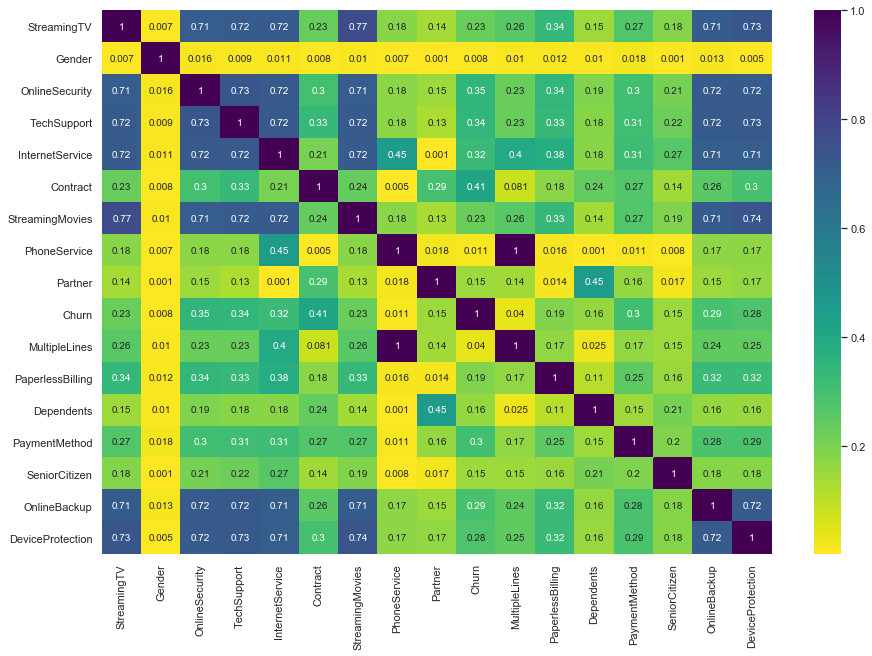

In [21]:
# Heatmap of Cramer's V values
plt.figure(figsize=(15,10))
sb.heatmap(cramersv_df, annot=True, cmap = 'viridis_r')
plt.show()

We can also review a similar heatmap of p-values from the chi-squared test before interpreting. The p-values here are rounded to visualize more easily.

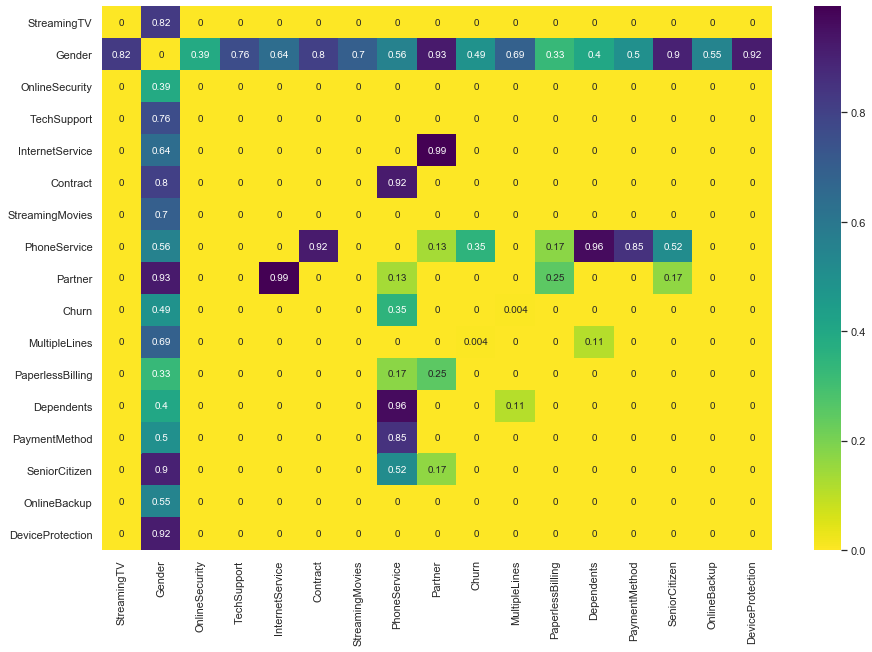

In [22]:
# Heatmap of p-values
plt.figure(figsize=(15,10))
sb.heatmap(pvals_df, annot=True, cmap = 'viridis_r')
plt.show()

In considering the above heatmaps, we can make the following arguments:
* Association exists between numerous categorical variable pairs, sometimes at considerable levels. We should consider a method that will take this into account.
 * Of particular note, `PhoneService` and `MultipleLines` show perfect correlation. At least one of these variables should be dropped.
* In regards to our response variable:
 * No obvious variables stand out as major predictors. Many variables might contribute a modest amount.
 * A few variables stand out as obvious candidates to be dropped having very low (<.10) Cramer's V values, and in some cases insignificant p-values. These are:  `Gender`, `PhoneService`, `MultipleLines`
 
Let's look at the distribution of effect sizes for churn directly though. Whereas we might not be able to use just a few variables as predictors, this might help us build intuitions about the dataset.

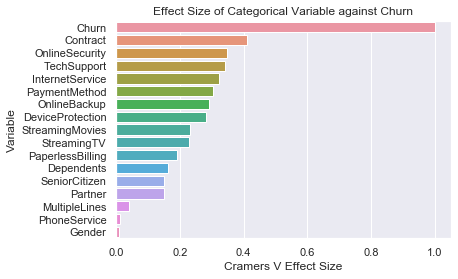

In [23]:
# Create a more easily plotable object off of that Pandas Series
cv_churn = cramersv_df['Churn'].reset_index()
# Sort the values by effect
cv_churn.sort_values(by='Churn', ascending=False, inplace=True)

# Plot the values
sb.barplot(y='index', x='Churn', data=cv_churn)
plt.ylabel("Variable")
plt.xlabel("Cramers V Effect Size")
plt.title("Effect Size of Categorical Variable against Churn")
plt.show()

`Churn` was kept in the above plot to keep the scale against a perfect effect size of 1 (`Churn` with itself). In reviewing this plot, might choose (albeit arbitrarily) to look at the variables with an effect size greater than 0.30 which yields the top 5 variables.

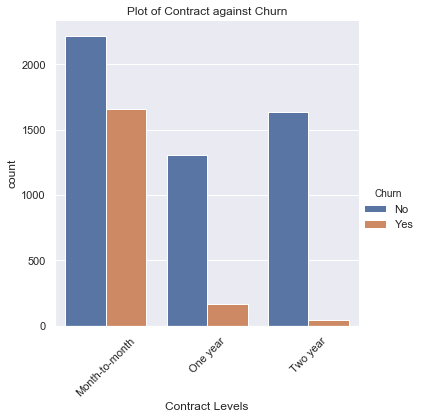

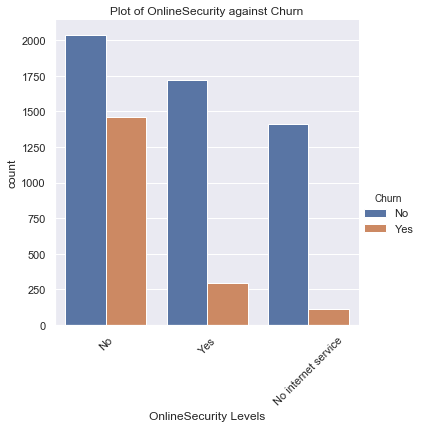

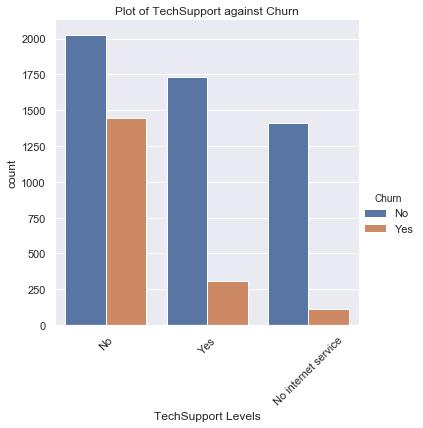

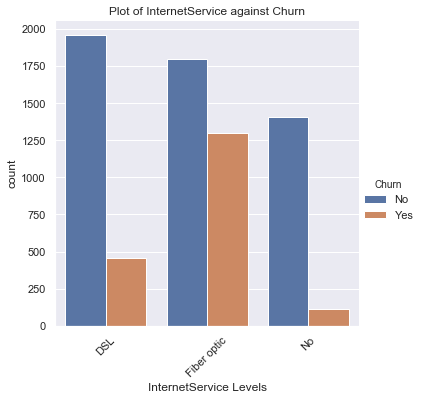

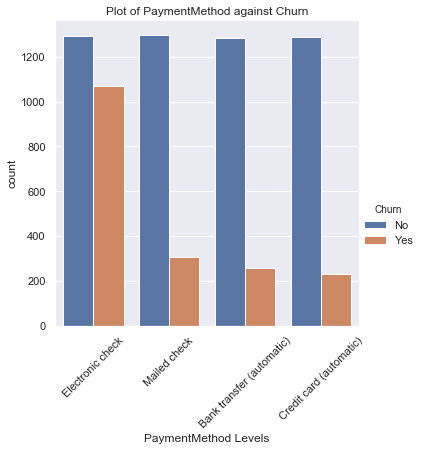

In [24]:
# Create list of top 5 categorical variables by effect size
top5_cat = cv_churn[cv_churn['Churn'] >= 0.3]['index'].to_list()[1:]
# In the above:  Masks for effect size >= 0.3, index col is var name, slice off first  val to remove 'Churn' listing

# Plot the bar graphs
for var in top5_cat:
    sb.catplot(x=var, hue='Churn', data=dfc, kind='count')
    plt.title("Plot of {} against Churn".format(var))
    plt.xlabel("{} Levels".format(var))
    plt.xticks(rotation=45)
    plt.show()

We can make the following arguments regarding the above variables relationship with `Churn`:
* For the `Contract` variable: Shorter contracts more likely to churn (especially 'Month-to-month').
* For the `OnlineSecurity` variable: Those without online security but having internet access more likely to churn.
* For the `TechSupport` variable: Those without tech support but having internet access more likely to churn.
* For the `InternetService` variable: Those with fiber optic internet access more likely to churn than those with DSL or no internet access.
* For the `PaymentMethod` variable: Those using electronic checks are more likely to churn than all other methods, each of the others having a fairly equal distribution.

In each case of the above, the level presenting a higher likelihood to churn nears a 50-50 split of churning or not, so none of these variables alone are sufficient as lone predictors. However, the levels where churning is less likely though are fairly predictive. Overall this paints a picture that customers who are more financially invested (longer contracts and have purchased security or tech support) are less likely too churn. While this is perhaps unsurprising, customers with fiber optic internet access and using electronic checks stand out as possibly warranting business review.

While this information is helpful for descriptive measures, it is clear that we would likely need to incorporate information from a number of variables for any predictive method as no obvious predictor stands out. This matches the expectations from our effect size analysis above.

### Conclusions From Bivariate Analysis

From our analysis of both the qualitative and quantitative variables above, we can summarize a number of findings --both descriptive in terms of relationships with churn as well as information for further predictive evaluation.

#### Relationships with Churn

*Numerical Variables*

In general a higher likelihood of customers churning is associated with:
* Lower `Tenure`
* Lower `TotalCharges`
* Higher `MonthlyCharges`
* Variance does not appear extreme, but the range of Churn being Yes/No for each variable definitely overlap and the means do not always appear obviously far apart.

The relationships above might seem as expected, though lower total charges being more related to churn seems somewhat strange. This may, however, simply reflect that customers who are highly invested in company services (and thus have more overall charges) tend not to churn due to investment and loyalty. While the `Tenure` variable had a high (>0.85) correlation coefficient, we likely do not want to rely on this variable alone for prediction as the relationship can be somewhat tautological (customers who tend to stay with the company of course have longer tenure).

*Categorical Variables*

Among the variables most highly associated with customer churn (by Cramer's V), we can argue the following relationships:

* For the `Contract` variable: Shorter contracts more likely to churn (especially 'Month-to-month').
* For the `OnlineSecurity` variable: Those without online security but having internet access more likely to churn.
* For the `TechSupport` variable: Those without tech support but having internet access more likely to churn.
* For the `InternetService` variable: Those with fiber optic internet access more likely to churn than those with DSL or no internet access.
* For the `PaymentMethod` variable: Those using electronic checks are more likely to churn than all other methods, each of the others having a fairly equal distribution.

In each case of the above, the level presenting a higher likelihood to churn nears a 50-50 split of churning or not, so none of these variables alone are sufficient as lone predictors. However, the levels where churning is less likely though are fairly predictive. Overall this paints a picture that customers who are more financially invested (longer contracts and have purchased security or tech support) are less likely too churn. While this is perhaps unsurprising, customers with fiber optic internet access and using electronic checks stand out as possibly warranting business review.

#### General Predictive Considerations

For building a predictive model, we can distill a few key claims regarding the dataset:

* No obvious predictors except for possibly `Tenure` stand out (having an effect size > 0.85). As noted above, the `Tenure` variable is likely tautological and should not be relied on alone. Contribution to the response is likely spread out amongst the other predictors.
* Considerable correlation exists amongst the predictors. We should consider using methods where this is not a problem.
* High dimensionality remains an issue. We only have strong cause to drop a few variables (each with a low Cramer's V)- `Gender`, `PhoneService`, and `MultipleLines`.

## Data Preparation for Predictive Methods

In order to employ predictive methods on our dataset, we employ the following suggestions from our analysis above:
* Drop the variables `Gender`, `PhoneService`, and `MultipleLines`.
* Employ a factor/component analysis technique for dimension reduction.

We will also need to split our data into appropriate training and testing sets.

We will implement two different predictive techniques here for comparsion. Since the target is binary, we'll try a logistic regression classifier. And since our data will already be a black box of sorts due to factor analysis, we'll also try a random forest.

### Cleaned Dataset

First let's drop the determined variables and redefine our features and target. We'll also save a cleaned csv file at this step for safekeeping.

In [25]:
# Drop the determined columns
dfc = dfc.drop(columns=['Gender', 'PhoneService', 'MultipleLines'])

# Create new features list for convenience
cfeatures = features
cfeatures.remove('Gender')
cfeatures.remove('PhoneService')
cfeatures.remove('MultipleLines')

# Export the cleaned data to a csv file
dfc.to_csv("Cleaned_WA_Fn-UseC_-Telco-Customer-Churn.csv")

# We can now safely delete the original df
del df

### Dimension Reduction Exploration

We will need to rework our factor/component analysis after our train-test split, but let's run it in a descriptive fashion on the whole dataset to get a sense of how many components we can reduce our data to.

Before doing so, however, we should standardize our numeric values to remove any bias from the analysis. Let's also create a new dataframe to work on for this.

In [26]:
# Copying the cleaned dataframe
df_factors = dfc[cfeatures].copy()

# Subtracting mean and dividing by standard deviation on quantitative columns
df_factors[quantcols] = StandardScaler().fit_transform(df_factors[quantcols])

Now let's use factor analysis on our mixed data ("FAMD") to try and reduce our dimensions some. We can use the imported `prince` package to handle this for us.

In [27]:
# Initial the FAMD object
famd = prince.FAMD(n_components=16, copy=True, random_state=42)
# Fit it to our data
famd.fit(df_factors[cfeatures])
# Transform and store our data
df_factors = famd.fit_transform(df_factors[cfeatures])
# Join the new factors with the response variable
df_factors['Churn'] = dfc['Churn']

# Check the output
df_factors.head()

0           1           2           3           4           5  \
0  313.834918  -77.970124  -58.697849   69.697424   81.473288  -95.580190   
1  266.059387    1.095228  -27.876073  172.102853 -119.134023   64.013839   
2  297.242367  -43.405085  -80.696279  127.225305  -65.977408 -141.531462   
3  254.175821    3.888559   37.973238  180.167585 -160.632709   40.700657   
4  329.572723 -100.271175 -175.930498  -11.081155   31.524226  -28.025874   

           6           7          8           9         10         11  \
0  67.052179  -41.233774 -31.130447  -47.348514  97.591629 -33.629338   
1  -3.028423  101.572965 -43.540320  115.630176  45.373174  60.091103   
2  40.178139  -38.076902  26.360287   79.172111  65.962592 -36.641488   
3 -23.852413  106.775267 -17.784808   14.263083 -47.299314  69.175984   
4 -15.429245    8.512392  -3.905696   19.661055 -60.337702  -0.435072   

          12         13         14         15 Churn  
0  23.605635   0.145738 -15.503825 -74.032547    No  
1  43.086468  13.837094 -34.076899  52.627975    No  
2 -30.949821  12.497562  -4.662548  63.678412   Yes  
3  32.689426  28.294174 -94.722653 -25.022254    No  
4  21.522574 -11.350340 -11.740784 -47.980460   Yes

Now let's do a few plots on our factors to see what a reasonable reduction would be. By viewing how many factors are needed to explain sufficient variance in the dataset overall, we can then generalize that cut-off point to further prep stages.

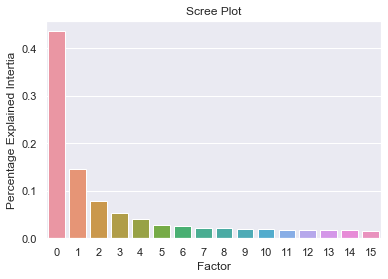

In [28]:
# Bar plot of explained intertia by factor
inertias = famd.explained_inertia_
sb.barplot(x=list(range(16)), y=inertias) # The famd output is just an array so providing a range as labels
plt.title("Scree Plot")
plt.ylabel("Percentage Explained Intertia")
plt.xlabel("Factor")
plt.show()

Let's feign optimism momentarily to see if only keeping the first two primary factors would sufficiently discriminate the target.

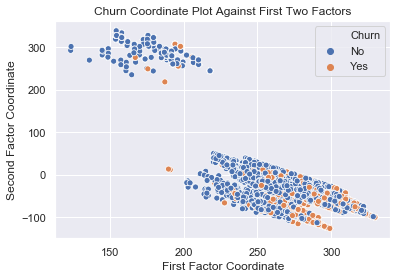

In [29]:
sb.scatterplot(x=0, y=1, hue='Churn', data=df_factors)
plt.title('Churn Coordinate Plot Against First Two Factors')
plt.ylabel('Second Factor Coordinate')
plt.xlabel('First Factor Coordinate')
plt.show()

Finally, let's plot the cumulative intertia explained when keeping n factors.

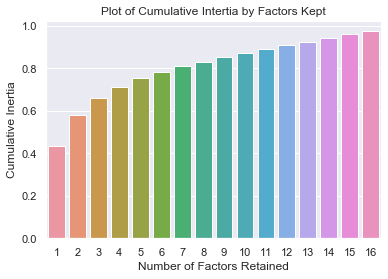

In [30]:
# First create the values for cumulative inertia explained
cumu_inertia = [0] # Starting with 0 so we can add the "previous" value in the list
for i, val in enumerate(inertias):
    previous = cumu_inertia[i]
    cumu_inertia.append(val + previous)
cumu_inertia.remove(0)

# Plot of cumulative retained inertia
sb.barplot(x=list(range(1, 17)), y=cumu_inertia) # The famd output is just an array so providing a range as labels
plt.title("Plot of Cumulative Intertia by Factors Kept")
plt.ylabel("Cumulative Inertia")
plt.xlabel("Number of Factors Retained")
plt.show()

From the coordinate vs response plot above, we see that clearly we will need multiple factors (beyond at least 2) to explain the variance in `Churn`. From reviewing the other two charts, we see two possible approaches in determining how many factors to retain. If we look for the "elbow" in the inertia plot, this appears to be roughly after the 3rd factor and then levels out around the 8th factor. However, if we were to go by the cumulative intertia retained, we can see that we would have to retain at least 8 factors to explain ~80% of the inertia (a little more than 60% at 3 factors kept). At 8 factors this however still cuts the number of dimensions in half. As the number of observations for this dataset is relatively small (low thousands), we will choose the larger number and generalize to retaining 8 factors in futher analysis.

In [31]:
# We will rebuild our factor analysis off of training data, so this run can be deleted
del df_factors

### Train/Validate/Test Set Preparations

How we split our data here needs to be somewhat informed by our predictive method. If we were using only SciKitLearn classifiers, we might could build a data pipeline with standardized and FAMD that allows cross-validation. However I would like to utilize StatsModel's logistic regression functions also which does not fit well within SciKitLearn's cross-validation structure. As we want to do the data preparation for all models in the same manner, we will choose to directly split out a validation set instead of using cross-validation. As the number of observations in the dataset are in the thousands, this likely does not cause us to lose too much information.

We will choose to do a 60/20/20 train/validate/test split here via multiple successions of SciKitLearn's train-test-split utility.

In [32]:
# Create our features vs targets
X = dfc[cfeatures]
y = dfc['Churn']

# Run the first split: test vs train and validation (tv)
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Run the second split: train vs validation (have to change test size here to account for first split)
X_train, X_validate, y_train, y_validate = train_test_split(X_tv, y_tv, test_size=0.25, random_state=42, stratify=y_tv)

# Double check the shape to check the results
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)
print(X_test.shape, y_test.shape)

(4218, 16) (4218,)
(1407, 16) (1407,)
(1407, 16) (1407,)


Since our validate and test sets should be prepared in exactly the same way as the train dataset, we'll standardize and run FAMD dimensionality reduction off of the fit from the train data set.

Let's also rename the factors so they aren't confused with numerical values.

In [33]:
# Fit the standard scaler to the train features
sc = StandardScaler().fit(X_train[quantcols])
# Go ahead and transform the quantitative train features as will be used in FAMD
# But create a copy to work on in case need originals ("t" for transformed)
Xt_train = X_train.copy()
Xt_train[quantcols] = sc.transform(Xt_train[quantcols])
# Initialite a new FAMD object keeping 8 components (as determined above)
famd = prince.FAMD(n_components=8, copy=True, random_state=42)
# Fit the FAMD object to our train features
famd.fit(Xt_train)
Xt_train = famd.transform(Xt_train)

# Transform oun our remaining validate/test datasets accordingly ("t" for transformed)
Xt_validate = X_validate.copy()
Xt_validate[quantcols] = sc.transform(Xt_validate[quantcols])
Xt_validate = famd.transform(Xt_validate)
Xt_test = X_test.copy()
Xt_test[quantcols] = sc.transform(Xt_test[quantcols])
Xt_test = famd.transform(Xt_test)

# Rename the factors so they are clearly labels and not numbers
rename_dict = {0: 'F1', 1: 'F2', 2: 'F3', 3: 'F4', 4: 'F5', 5: 'F6', 6: 'F7', 7: 'F8'}
Xt_train.rename(columns=rename_dict, inplace=True)
Xt_validate.rename(columns=rename_dict, inplace=True)
Xt_test.rename(columns=rename_dict, inplace=True)

Let's print the head of each to double check the results.

In [34]:
Xt_train.head()

F1          F2          F3          F4         F5         F6  \
1646  178.713923   26.316127   89.909922  193.700141 -27.153737 -24.529402   
2735  225.668280  -86.108852 -128.774687  -11.472891 -15.002882 -34.854030   
6476  178.959987   18.106138  104.247872  185.691703 -29.960061 -29.244545   
2588  232.341352  -34.089237  -88.356479  108.737719  51.587915  60.716260   
4667  148.538803  229.602235  -33.816278  -19.262401 -26.968810  18.989266   

             F7         F8  
1646  33.516426 -29.415149  
2735   6.406390  68.705826  
6476  46.279718 -12.817501  
2588 -16.014974 -33.386500  
4667  39.712380  37.496023

In [35]:
Xt_validate.head()

F1          F2          F3         F4         F5         F6  \
5157  102.916561   15.346463   85.995663  77.402367  -8.840434   1.354259   
5028  121.974760  -13.124437   66.417955 -51.530337  65.153734 -23.893448   
3779   86.028056    7.651323  104.129987  50.092064   3.467309   2.406522   
6560   69.330016  145.993962  -19.431158   7.600858   3.444591  16.128332   
863   143.777549  -39.880538  -22.161465 -65.156505   9.078268  -9.605365   

             F7         F8  
5157  20.995499 -14.551584  
5028   2.218598  -7.923897  
3779  34.113216  16.891366  
6560  -3.357327 -25.840894  
863   21.259378 -54.052116

In [36]:
Xt_test.head()

F1          F2         F3         F4         F5         F6  \
974   113.242965   -4.169263  88.437024   5.485970 -22.567976 -19.583598   
619   141.617893  -34.899446 -51.264180   4.414209   1.352204 -54.629988   
4289   79.004973  144.863983 -31.645780  -7.258152  40.500651   8.087792   
3721   87.100219  134.785127 -56.760207  -9.814536  31.279785  13.400109   
4533  127.772872  -16.567332  65.793237 -62.511833  -4.873563 -13.836021   

             F7         F8  
974  -25.516703 -64.154113  
619   34.709912 -19.308516  
4289   8.184929  -0.066404  
3721   8.916775  -8.100344  
4533  28.063744  -1.099792

All looks well. We can now begin work on building our predictors. Now let's prep our target "Yes" and "No" values as 1's/0's for model building.

In [37]:
# Replace the values in each of our target sets with 1's and 0's accordingly
replace_dict = {'Yes': 1, 'No': 0}
y_train.replace(replace_dict, inplace=True)
y_validate.replace(replace_dict, inplace=True)
y_test.replace(replace_dict, inplace=True)

Finally let's combine our target and features into new dataframes and save as csv files for posterity.

In [38]:
# Combine the target and feature variables for each set and store as a csv
df_train = Xt_train.copy()
df_train['Churn'] = y_train
df_train.to_csv('PreparedTrain_WA_Fn-UseC_-Telco-Customer-Churn.csv')

df_validate = Xt_validate.copy()
df_validate['Churn'] = y_validate
df_validate.to_csv('PreparedValidate_WA_Fn-UseC_-Telco-Customer-Churn.csv')

df_test = Xt_test.copy()
df_test['Churn'] = y_test
df_test.to_csv('PreparedTest_WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Predictive Evaluation

As noted above, we have chosen to implement two different predictive techniques here for comparsion. Since the target is binary, we'll try a logistic regression classifier (using StatsModels). And since our data will already be a black box of sorts due to factor analysis, we'll also try a random forest (using SciKitLearn).

### Logistic Regression

We'll implement logistic regression using StatsModels due to the richness of statistical data it provides. As all of our predictors are now factor components and can't be interpretted directly, we'll use stepwise regression to pick how many factors to retain in the model. We can reasonably use a forward step-wise method as the factors, listed in ascending order, are in the order of the variance they account for in the dataset. As such, our goal then is to maximize parsimony (so as to avoid overfitting) while simultaneously retaining predictive power.

Unfortunately the statistical data that can be utilized here (AIC/BIC/R^2 scores) can only be obtained for the data the model is fitted on. As such, we must train and make our determination of which predictors to use on the training data set. We can use the validation set later for running an ROC curve however.

Below we iteratively run each model (in a forward-stepwise fashion) and collect relevant information from each in a Pandas dataframe.

In [39]:
# Create predictors list to use as part of the stepw-wise iterations
predictors = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']
current_predictors = []

# Create empty list to store information about each step
step_data = []
predictors_data = []
AIC_data = []
BIC_data = []
R2_data = []

# Implement the step-wise regression
for var in predictors:
    
    # Set up out string for the logit function
    current_predictors.append(var)
    model_string = "Churn" + " ~ " + " + ".join(current_predictors)
    # Fit the model
    logit_model = logit(formula=model_string, data=df_train)
    logit_fitted = logit_model.fit()
    
    # Collect statistics from the fitted model
    step_data.append(var)
    predictors_data.append(list(current_predictors)) # We're adding lists to a list here
    AIC_data.append(logit_fitted.aic)
    BIC_data.append(logit_fitted.bic)
    R2_data.append(logit_fitted.prsquared)

# Finally create and view our Pandas dataframe off of the collected data to ensure it worked    
df_models = pd.DataFrame(data={'Term_Added':step_data, 'Full_Model':predictors_data,
                               'AIC':AIC_data, 'BIC':BIC_data, 'Pseudo_R2':R2_data})
df_models

Optimization terminated successfully.
         Current function value: 0.484467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436103
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435950
         Iterations 7


Term_Added                        Full_Model          AIC          BIC  \
0         F1                              [F1]  4090.966061  4103.660294   
1         F2                          [F1, F2]  4092.882702  4111.924051   
2         F3                      [F1, F2, F3]  3924.262223  3949.650688   
3         F4                  [F1, F2, F3, F4]  3746.524029  3778.259611   
4         F5              [F1, F2, F3, F4, F5]  3713.677840  3751.760538   
5         F6          [F1, F2, F3, F4, F5, F6]  3693.694079  3738.123894   
6         F7      [F1, F2, F3, F4, F5, F6, F7]  3694.968815  3745.745746   
7         F8  [F1, F2, F3, F4, F5, F6, F7, F8]  3695.672713  3752.796760   

   Pseudo_R2  
0   0.163271  
1   0.163289  
2   0.198220  
3   0.235018  
4   0.242152  
5   0.246653  
6   0.246801  
7   0.247066

Now that we've got statistics on each of the model versions, let's print a couple plots to evaluate them.

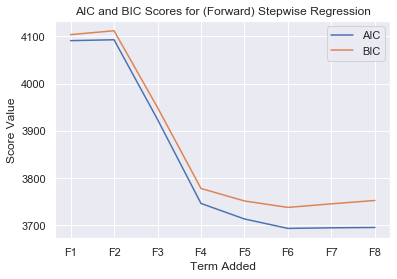

In [40]:
# Line plot of AIC/BIC values for stepwise regression
sb.lineplot(x='Term_Added', y='AIC', data=df_models)
sb.lineplot(x='Term_Added', y='BIC', data=df_models)
plt.legend(['AIC', 'BIC'])
plt.title('AIC and BIC Scores for (Forward) Stepwise Regression')
plt.ylabel('Score Value')
plt.xlabel('Term Added')
plt.show()

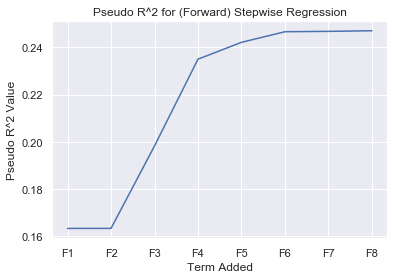

In [41]:
# Line plot of AIC/BIC values for stepwise regression
sb.lineplot(x='Term_Added', y='Pseudo_R2', data=df_models)
plt.title('Pseudo R^2 for (Forward) Stepwise Regression')
plt.ylabel('Pseudo R^2 Value')
plt.xlabel('Term Added')
plt.show()

In reviewing the charts we can see a clear winner at step F6. At this point the pseudo R^2 value nearly flatlines, signifying we're not gaining much predictive power for adding more terms. Simultaneous this step is also the minimum on the curve for both AIC and BIC values, suggesting good parsimony compared to predictive power.

Given this, we'll build our model accordingly.

In [64]:
# Build our model and print summary results
logit_model = logit(formula='Churn ~ F1 + F2 + F3 + F4 + F5 + F6', data=df_train)
logit_fitted = logit_model.fit()
print(logit_fitted.summary2())

Optimization terminated successfully.
         Current function value: 0.436189
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.247      
Dependent Variable: Churn            AIC:              3693.6941  
Date:               2019-12-27 12:40 BIC:              3738.1239  
No. Observations:   4218             Log-Likelihood:   -1839.8    
Df Model:           6                LL-Null:          -2442.2    
Df Residuals:       4211             LLR p-value:      4.4549e-257
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     -3.6427    0.6928   -5.2579  0.0000  -5.0006  -2.2849
F1             0.0115    0.0033    3.4943  0.0005

At a quick glance, we notice that all terms appear statistically significant. The Pseudo R-squared value seems a bit low at around .25, but given the context of the data, this may be unsurprising, and the model might still have significant predictive power.

With our general model built, we should now determine an appropriate threshold value for predicting our target. We can also evaluate the model on measures such as its accuracy and specificity. This then is a good opportunity to use our validation set.

As we are largely interested in our positive target case, customers who churn, we are especially interested in sensitivity. We also want to minimize false positives however. One way of reviewing this is through an ROC curve, which we can implement through SciKitLearn below.

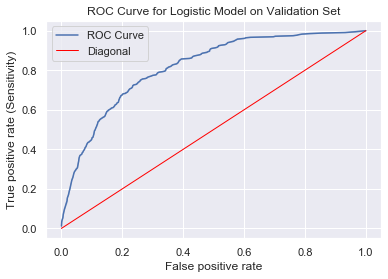

In [65]:
# First to store our predicted values when applied to the validation set
predicted_vals = logit_fitted.predict(df_validate.loc[:, 'F1':'F6'])

# Calculating the values needed for the ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_validate.Churn, predicted_vals)

# Plotting the ROC curve
sb.lineplot(y=true_pos_rate, x=false_pos_rate)
plt.plot([0,1],[0,1], 'red', linewidth=1)
plt.title('ROC Curve for Logistic Model on Validation Set')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Sensitivity)")
plt.legend(labels=['ROC Curve', 'Diagonal'])
plt.show()

An ROC curve that "bows" up and to the left away from the diagonal represents better fitting locations for the model. We can also review another common metric, the AUC score, for our model using the information already created.

In [66]:
# Create and print our AUC score
auc_score_logit = roc_auc_score(df_validate.Churn, predicted_vals)
auc_score_logit

0.8153928384695426

AUC scores closer to 1 represent better models. We can use this to compare to our other model later. For now, let's use the information we've generated to programmatically select the optimum threshold.

In [67]:
# Find the index with the highest difference in true vs false positive rates
optimal_idx = np.argmax(true_pos_rate - false_pos_rate)
# And then lookup the corresponding threshold value
optimal_threshold_logit = thresholds[optimal_idx]
optimal_threshold_logit

0.10766583226113698

That produced threshold seems fairly low. Let's create a quick confusion matrix (via SciKitLearn) to compare this threshold against a typical 0.5 threshold to double check. Let's also print the accuracies and sensitivities.

In [68]:
# First determine the predictions at each threshold
predicted_optimal = (predicted_vals >= optimal_threshold_logit)
predicted_default = (predicted_vals >= 0.5)

# Create the confusion matrices
cfn_matrix_optimal = confusion_matrix(y_true=df_validate.Churn, y_pred=predicted_optimal)
cfn_matrix_default = confusion_matrix(y_true=df_validate.Churn, y_pred=predicted_default)

# Convert to pandas dataframes for easier visualization
cfn_df_optimal = pd.DataFrame(cfn_matrix_optimal, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])
cfn_df_default = pd.DataFrame(cfn_matrix_default, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

# Calculate overall accuracy
optimal_accuracy_logit = cfn_matrix_optimal.diagonal().sum() / cfn_matrix_optimal.sum().sum() # Sum twice to get both axis
default_accuracy_logit = cfn_matrix_default.diagonal().sum() / cfn_matrix_optimal.sum().sum()
# Calculate sensitivity
optimal_sensitivity_logit = cfn_df_optimal.loc['Actual Positive', 'Predicted Positive'] / cfn_df_optimal.loc['Actual Positive'].sum()
default_sensitivity_logit = cfn_df_default.loc['Actual Positive', 'Predicted Positive'] / cfn_df_default.loc['Actual Positive'].sum()

# Print results
print("For optimal threshhold", "\n")
print("Accuracy is {}".format(optimal_accuracy_logit))
print("Sensitivity is {}".format(optimal_sensitivity_logit))
print(cfn_df_optimal)
print("\n")
print("For default threshhold", "\n")
print("Accuracy is {}".format(default_accuracy_logit))
print("Sensitivity is {}".format(default_sensitivity_logit))
print(cfn_df_default)

For optimal threshhold 

Accuracy is 0.7434257285003554
Sensitivity is 0.7513368983957219
                 Predicted Negative  Predicted Positive
Actual Negative                 765                 268
Actual Positive                  93                 281


For default threshhold 

Accuracy is 0.7341862117981521
Sensitivity is 0.0
                 Predicted Negative  Predicted Positive
Actual Negative                1033                   0
Actual Positive                 374                   0


Putting aside the difference between the optimal and default threshholds for a moment, the accuracy values here look reminiscent to the class distribution. Let's run a quick simulataion to double check that it's actually better than chance.

In [94]:
# Store the length of the validate set and the frequencies in the target
n = len(df_validate)
yes_total = (df_validate['Churn']==1).sum()
yes_freq = yes_total / n
no_total = (df_validate['Churn']==0).sum()
no_freq = no_total / n

# Create empty lists to store information from our loop
sim_accuracy_list = []
sim_sensitivity_list = []
actual_pos_list = []
actual_neg_list = []
false_pos_list = []
false_neg_list = []

# Run our simulation 10000 times
for i in range(10000):
    
    # Create a simulated array randomly picking 0 or 1 according to the frequencies in the target and size of set
    simulated_predictions = np.random.choice([0,1], size=n, p=[no_freq, yes_freq])
    
    # Calculate accuracy and append to list
    sim_accuracy = (simulated_predictions == df_validate.Churn).mean()
    sim_accuracy_list.append(sim_accuracy)
    
    # Calculate sensitivity and append to list
    actual_pos = ((simulated_predictions == 1) & (simulated_predictions == df_validate.Churn)).sum()
    sensitivity = actual_pos / yes_total
    sim_sensitivity_list.append(sensitivity)
    
    # Calculate other values for the confusion matrix and append to lists
    actual_pos_list.append(actual_pos)
    actual_neg = ((simulated_predictions == 0) & (simulated_predictions == df_validate.Churn)).sum()
    actual_neg_list.append(actual_neg)
    false_pos = ((simulated_predictions == 1) & (simulated_predictions != df_validate.Churn)).sum()
    false_pos_list.append(false_pos)
    false_neg = ((simulated_predictions == 0) & (simulated_predictions != df_validate.Churn)).sum()
    false_neg_list.append(false_pos)
    
    # Counter to track progress
    print("{} of {} completed".format((i+1), 10000), end="\r")
    
# Create a Pandas dataframe of the average confusion matrix for the simulation
avg_actual_pos = round(np.mean(actual_pos_list), 2)
avg_actual_neg = round(np.mean(actual_neg_list), 2)
avg_false_pos = round(np.mean(false_pos_list), 2)
avg_false_neg = round(np.mean(false_neg_list), 2)
cfn_matrix_sim = [[avg_actual_neg, avg_false_pos], [avg_false_neg, avg_actual_pos]]
cfn_df_sim = pd.DataFrame(cfn_matrix_sim, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

# Calculate the accuracy and sensitivity from mean of simulation
sim_accuracy = np.mean(sim_accuracy_list)
sim_sensitivity = np.mean(sim_sensitivity_list)

# Print the results
print("For random chance picking", "\n")
print("Accuracy is {}".format(sim_accuracy))
print("Sensitivity is {}".format(sim_sensitivity))
print("\n")
print("Average confusion matrix from all runs of simulation")
print(cfn_df_sim)

For random chance picking 

Accuracy is 0.6097245913290689
Sensitivity is 0.2657858288770053


Average confusion matrix from all runs of simulation
                 Predicted Negative  Predicted Positive
Actual Negative              758.48              274.52
Actual Positive              274.52               99.40


The above comparisons make it clear that our model with the determined optimal threshold peforms better than the model and the default (0.5) threshold and better than by chance. Whereas the default threshold has comprable accuracy, it utterly fails to discriminate positive cases and thus has 0 sensitivity. Compared to picking by chance, our model only has an additional ~15% accuracy but has more than double the sensitivity. As we are most interested in finding the positive target cases (customers who churn), our model can pick churning customers almost twice as well, along with a slight overall accuracy boost.

We should now move onto our random forest model to see how it might compare.

### Random Forest

SciKitLearn has a convenient and easy-to-fit random forest implementation that we will use. Most of the work for this classifier is through tuning the hyperparameters. While typically this would be done through cross-validation on a training dataset, we are wanting to compare this model to that of our logistical regression model (which doesn't work with SciKitLearn's cross validation classes). As such, we'll do hyperparameter tuning directly on our validation set. We can, however, use SciKitLearn's `ParameterGrid` function to build a grid of hyperparameters that can be easily iterated through. We'll do that first below.

The hyperparameters chosen below are part from SciKitLearn's [documentation suggestions](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) and part from my own general knowledge, as well as some arbitrary additions to the grid to get good coverage.

In [78]:
# Create a grid of parameters to search through
param_grid = ParameterGrid({'n_estimators':[5, 10, 25, 100], 'max_features':[None,"sqrt",6], 
                           'max_depth':[None, 4, 6], 'min_samples_split':[2,5,10,25,40], 'random_state':[42],
                           'criterion':['gini','entropy'], 'min_samples_leaf':[1,2,5,10,20],
                           'class_weight':['balanced', {0:0.75, 1:0.25}]})

# Define the length of the grid so we can keep track
grid_length = len(list(param_grid))

With the grid built, we'll exhaustively iterate through each possible parameter combination. At each step, we train the classifier on the training data and then test it with our hyperparameters on the validation set. We store the results each time. Since we are especially interesting in capturing customers who might churn, we'll store both sensitivity and accuracy at each step.

In [70]:
# Create empty lists to append values into during parameter search
params_list = []
accuracy_list = []
sensitivity_list = []
# This value will be used multiple times in the iterations
tot_pos = (y_validate == 1).sum()

# Iterate through the grid
for i, param_set in enumerate(param_grid):
    
    # Create and fit our classifier on the training data
    rf = RandomForestClassifier(**param_set)
    rf.fit(Xt_train, y_train)
    # Calculate the predicted values on the validation set
    predicted_vals = rf.predict(Xt_validate)
    
    # Calculate accuracy and sensitivity
    accuracy = (predicted_vals == y_validate).mean()
    matched_pos = ((predicted_vals == 1) & (predicted_vals == y_validate)).sum()
    sensitivity = matched_pos / tot_pos
    
    # Append outputs to our lists
    params_list.append(param_set)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print a status tracker during iteration
    print("{} of {} completed".format((i+1), grid_length), end="\r")

With the iterations complete, let's build a Pandas dataframe of the results and sort by sensitivity and then accuracy.

In [79]:
# Create a Pandas dataframe on our results for easy viewing
df_rf = pd.DataFrame(data={'Step':list(range(1,grid_length+1)),'Accuracy':accuracy_list, 
                           'Sensitivity':sensitivity_list, 'Params':params_list})

# Sort the dataframe first by Sensitivity then Accuracy
df_rf.sort_values(by=['Sensitivity', 'Accuracy'], ascending=False, inplace=True)
# Allow the colums to be wide enough to view the params
pd.set_option('display.max_colwidth', 300)

# Print the top 10 results
df_rf.head(10)

Step  Accuracy  Sensitivity  \
216    217  0.766169     0.502674   
852    853  0.766169     0.483957   
856    857  0.769012     0.478610   
737    738  0.770434     0.465241   
1637  1638  0.769723     0.462567   
840    841  0.766169     0.459893   
844    845  0.766169     0.459893   
848    849  0.766169     0.459893   
1638  1639  0.774698     0.457219   
717    718  0.769723     0.454545   

                                                                                                                                                                                    Params  
216         {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 40, 'n_estimators': 5, 'random_state': 42}  
852            {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 25, 'n_estimators': 5, 'random_state': 42}  
856            {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 5, 'random_state': 42}  
737      {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 40, 'n_estimators': 10, 'random_state': 42}  
1637  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 40, 'n_estimators': 10, 'random_state': 42}  
840             {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 5, 'random_state': 42}  
844             {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 5, 'random_state': 42}  
848            {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 5, 'random_state': 42}  
1638  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 40, 'n_estimators': 25, 'random_state': 42}  
717      {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 40, 'n_estimators': 10, 'random_state': 42}

We can use this dataframe to pick our best hyperparameters, but let's do a couple of plots to visualize it's contents. First a plot of the accuracy at each step, and then one for the sensitivity.

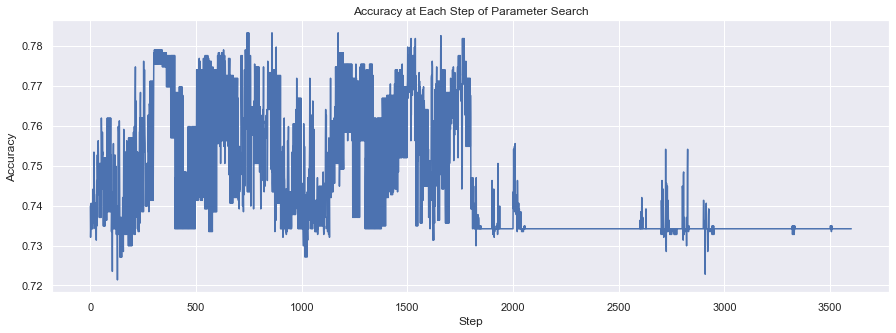

In [84]:
# Plot of accuracy for parameter search
plt.figure(figsize=(15,5))
sb.lineplot(x='Step', y='Accuracy', data=df_rf)
plt.title("Accuracy at Each Step of Parameter Search")
plt.show()

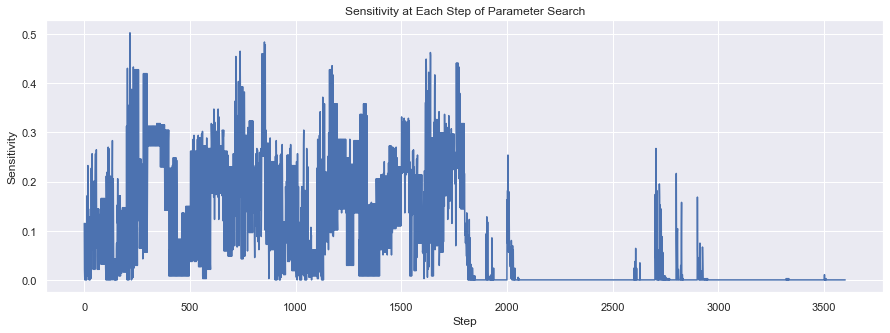

In [85]:
# Plot of accuracy for parameter search
plt.figure(figsize=(15,5))
sb.lineplot(x='Step', y='Sensitivity', data=df_rf)
plt.title("Sensitivity at Each Step of Parameter Search")
plt.show()

We can see from the above charts that, while most parameter sets tend to hover around 75% accuracy, we have fairly wide swings in sensitivity. Particularly step 217 has the highest sensitivty at around 0.5, matching the top result in our dataframe, as well as one of the higher accuracies in the plot. This then is the clear winner and should be used as the best parameter set.

Let's rebuild the model using this parameter set, train it on the training data, and then predict our validation set using it.

In [88]:
# Set up our final random forest model using the determined best parameters
rf_best_params = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 6,
                  'min_samples_leaf': 1, 'min_samples_split': 40, 'n_estimators': 5, 'random_state': 42}
rf = RandomForestClassifier(**rf_best_params)
rf.fit(Xt_train, y_train)

# Predict the values for the validation set
predicted_vals = rf.predict(Xt_validate)

With the validation set values predicted, we can now use the same evaluation methods as we did on our logistic model. As we've already explained those above, we'll simply implement them all directly now here for the random forest model.

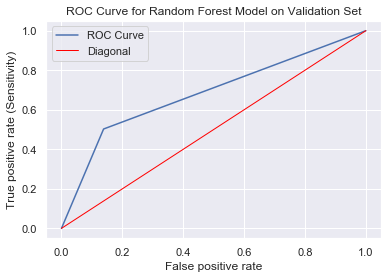



Random Forest AUC Score is 0.6821210223066609


For random forest model 

Accuracy is 0.7661691542288557
Sensitivity is 0.5026737967914439
                 Predicted Negative  Predicted Positive
Actual Negative                 890                 143
Actual Positive                 186                 188


In [96]:
# Calculating the values needed for the ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_validate.Churn, predicted_vals)

# Plotting the ROC curve
sb.lineplot(y=true_pos_rate, x=false_pos_rate)
plt.plot([0,1],[0,1], 'red', linewidth=1)
plt.title('ROC Curve for Random Forest Model on Validation Set')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Sensitivity)")
plt.legend(labels=['ROC Curve', 'Diagonal'])
plt.show()

# Create and print our AUC score
auc_score_rf = roc_auc_score(df_validate.Churn, predicted_vals)
print("\n")
print("Random Forest AUC Score is {}".format(auc_score_rf))

# Create the confusion matrix
cfn_matrix_rf = confusion_matrix(y_true=df_validate.Churn, y_pred=predicted_vals)

# Convert to pandas dataframes for easier visualization
cfn_df_rf = pd.DataFrame(cfn_matrix_rf, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

# Calculate overall accuracy and sensitivity
accuracy_rf = cfn_matrix_rf.diagonal().sum() / cfn_matrix_rf.sum().sum() # Sum twice to get both axis
# Calculate sensitivity
sensitivity_rf = cfn_df_rf.loc['Actual Positive', 'Predicted Positive'] / cfn_df_rf.loc['Actual Positive'].sum()

# Print results
print("\n")
print("For random forest model", "\n")
print("Accuracy is {}".format(accuracy_rf))
print("Sensitivity is {}".format(sensitivity_rf))
print(cfn_df_rf)

Our model has reasonable accuracy but misses almost half the positive target cases resulting in a modest sensitvity and AUC score. While arguably this model may be useful, we should compare it to our logistic model to determine which is better.

### Comparison of Models

Now that we have statistics on both our best logistic and random forest models, let's reprint them all out together for comparison. Let's add in accuracy and sensitivity measurements for if we were to pick our target by chance alone as well (from the simulation built previously).

In [95]:
# Print comparison of metrics for each of our models
print("For logit model")
print("Accuracy is:  {},  Sensitivity is {},  AUC score is {}".format(optimal_accuracy_logit,
                                                                      optimal_sensitivity_logit,
                                                                      auc_score_logit))
print()
print("For random forest model")
print("Accuracy is:  {},  Sensitivity is {},  AUC score is {}".format(accuracy_rf,
                                                                      sensitivity_rf,
                                                                      auc_score_rf))
print()
print("For picking by chance")
print("Accuracy is:  {},  Sensitivity is {}".format(sim_accuracy,
                                                                      sim_sensitivity))

For logit model
Accuracy is:  0.7434257285003554,  Sensitivity is 0.7513368983957219,  AUC score is 0.8153928384695426

For random forest model
Accuracy is:  0.7661691542288557,  Sensitivity is 0.5026737967914439,  AUC score is 0.6821210223066609

For picking by chance
Accuracy is:  0.6097245913290689,  Sensitivity is 0.2657858288770053


While both models perform better than chance with considerably higher accuracy, we see strong differences in AUC score and sensitivity between our logistic and random forest models. The random forest model has marginally higher accuracy but at the trade-off of about 25% sensitivity. As we are most interested in selecting positive cases within our target (customers who might churn), the logistic model should be selected as the favored model.

### Final Model Evaluation

We should now do one last test of our chosen model (the logistic model) on the test dataset to report it's score. We keep the model trained on just the training set and use it to predict the test set values below. We also implement the same evaluation tools used earlier in our process.

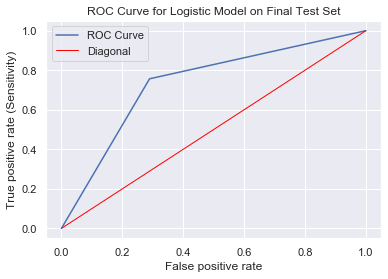



Final model AUC score is 0.73361814143945


Accuracy is 0.7228144989339019
Sensitivity is 0.7566844919786097
AUC score is 0.73361814143945


                 Predicted Negative  Predicted Positive
Actual Negative                 734                 299
Actual Positive                  91                 283


In [99]:
# Calculate the predicted values for the final test set
predicted_vals = logit_fitted.predict(df_test.loc[:, 'F1':'F6'])
# Convert the predicted values from probabilities to classified values
predicted_vals = (predicted_vals >= optimal_threshold_logit)

# Calculating the values needed for the ROC curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(df_test.Churn, predicted_vals)

# Plotting the ROC curve
sb.lineplot(y=true_pos_rate, x=false_pos_rate)
plt.plot([0,1],[0,1], 'red', linewidth=1)
plt.title('ROC Curve for Logistic Model on Final Test Set')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Sensitivity)")
plt.legend(labels=['ROC Curve', 'Diagonal'])
plt.show()

# Create and print our AUC score
auc_score_final = roc_auc_score(df_test.Churn, predicted_vals)
print("\n")
print("Final model AUC score is {}".format(auc_score_final))

# Create the confusion matrix
cfn_matrix_final = confusion_matrix(y_true=df_test.Churn, y_pred=predicted_vals)

# Convert to pandas dataframes for easier visualization
cfn_df_final = pd.DataFrame(cfn_matrix_final, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

# Calculate overall accuracy and sensitivity
accuracy_final = cfn_matrix_final.diagonal().sum() / cfn_matrix_final.sum().sum() # Sum twice to get both axis
# Calculate sensitivity
sensitivity_final = cfn_df_final.loc['Actual Positive', 'Predicted Positive'] / cfn_df_final.loc['Actual Positive'].sum()

# Print results
print("\n")
print("Accuracy is {}".format(accuracy_final))
print("Sensitivity is {}".format(sensitivity_final))
print("AUC score is {}".format(auc_score_final))
print("\n")
print(cfn_df_final)

The model's final results are positive, having similar values to the validation tests without evidence of strong under or overfitting. We could, if needed, then save this model for further use.